# Algorithme de reconnaissance d'image

pip freeze > requirements.txt

pip install -r requirements.txt

pip install coremltools

pip install keras_preprocessing livelossplot

# Packages nécessaires

In [1]:
print("début")
import os
import pandas as pd
import string
import random
import matplotlib
import numpy as np
#import coremltools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
get_ipython().run_line_magic('matplotlib', 'inline')
from tensorflow.keras import backend as K
from ast import literal_eval
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import PIL
import os
import os.path
from PIL import Image
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from keras.callbacks import TensorBoard
%load_ext tensorboard

début


# Caractéristiques du modèle

In [30]:
dir_images = './archive'
# Download dataset from https://www.kaggle.com/greg115/various-tagged-images
DATASET_PATH = dir_images +'/img_align_celeba/img_align_celeba' # Directory of the images with the following format "id-tag1_tag2.jpg"
METADATA_PATH = dir_images +'/list_attr_celeba.csv' #modif
RESIZED_PATH = dir_images+'/resized'
SPLIT_PATH = dir_images +'/list_eval_partition.csv'
MODEL_PATH = "saved_model/cp.h5"
IMAGE_PATH_KEY = "image_path"
TAGS_PATH_KEY = "tags"
NB_SELECTED = 1000
#MODEL_PATH = r"C:\Users\fifid\Documents\GitHub\projet-integrateur\Notebook\image_tagger.hdf5"
IMAGE_SIZE = 224 # pas modif car sinon pb avec fully connected
BATCH_SIZE = 32 #nb d'images en entrée du réseau en même temps
#VALIDATION_SPLIT = 0.1 # a modif
RANDOM_SEED = 115
EPOCHS = 100 #combien de fois on visualise l'ensemble des images du dataset, au moins 100
DROPOUT = 0.3 #0.2 ou 0.3
FULLY_CONNECTED = 1024
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = LEARNING_RATE/100.0
CONFIDENCE_THRESHOLD = 0.9
excluded_labels = ["Arched_Eyebrows","Attractive","Blurry","Double_Chin","Narrow_Eyes"]

# Resize des images

In [ ]:
print(" start ")

In [3]:
f = DATASET_PATH
DATASET_PATH = RESIZED_PATH
cnt = 0
cnt_erreur = 0
images = []

In [5]:

'''
for file in os.listdir(f):
    if cnt<NB_SELECTED:
        print(file)
        f_img = f+"/"+file
        try :
                img = Image.open(f_img) 
                img = img.resize((224,224))
                img.save(RESIZED_PATH+"/"+file)
                images.append(file)
                cnt +=1
                Image.close(f_img)
        except :
            images.pop()
            cnt_erreur +=1
            print("erreur",file)
    else :
        break
NB_SELECTED -= cnt_erreur
print("Fin resize")
'''

'\nfor file in os.listdir(f):\n    if cnt<NB_SELECTED:\n        print(file)\n        f_img = f+"/"+file\n        try :\n                img = Image.open(f_img) \n                img = img.resize((224,224))\n                img.save(RESIZED_PATH+"/"+file)\n                images.append(file)\n                cnt +=1\n                Image.close(f_img)\n        except :\n            images.pop()\n            cnt_erreur +=1\n            print("erreur",file)\n    else :\n        break\nNB_SELECTED -= cnt_erreur\nprint("Fin resize")\n'

In [4]:
images = []
for file in os.listdir(RESIZED_PATH):
    if cnt<NB_SELECTED:
        try : 
            images.append(file)
            cnt +=1
        except :
            print("pb avec ajout de l'image :", file)

In [5]:
print("Taille de images:",len(images))

Taille de images: 1000


# Load les datas

On se sert des recommandations sur le dataset : <br>
<br>
    "Recommended partitioning of the images into training, validation, testing sets. "0" represents training image, "1" represents validation image, "2" represents testing image. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing"<br>
    <br>
On utilise le fichier indiquant la répartition pour splitter les données.

In[289]:

In [11]:
print("Creation des df")

Creation des df


In [6]:
df_old = pd.read_csv(METADATA_PATH)
split_df = pd.read_csv(SPLIT_PATH)

df_old

split_df

# Optionnel : on change les répartitions Training/Testing/Validation

In [7]:
print(NB_SELECTED)
print(len(images))
part = [0 if i<(NB_SELECTED*0.7) else (1 if (i>=(NB_SELECTED*0.7) and i<NB_SELECTED*0.8) else 2) for i in range(NB_SELECTED)]
print(len(part))
split_df = pd.DataFrame(data={'image_path':images, split_df.columns[1]:part},
               columns =['image_path', split_df.columns[1]])

1000
1000
1000


In [ ]:
print("split df")

# Récupération des labels pour chaque image et mise en forme du dataframe

Pour chaque image on fait une liste des labels qui lui sont attribués. Dans une liste on stocke tout les labels qui sont à 1 pour cette image.

In [8]:
y = []
for row in df_old.iterrows():
    sub_y = []
    for i in range(1,len(row[1])) :
        if (int(row[1][i])==1) and (df_old.columns.values[i] not in excluded_labels):
            sub_y.append(df_old.columns.values[i])
    y.append(sub_y)
    
df = pd.DataFrame(list(zip(list(df_old[df_old.columns[0]]), y)),
               columns =['image_path', 'tags'])

on merge la répartion des images et leurs labels dans le même dataset

In [9]:
result = pd.merge(split_df, df,on='image_path')
#print(result)

df

result

# Split des data

In [10]:
training_df = result.loc[result['partition']==0]
validation_df = result.loc[result['partition']==1]
testing_df = result.loc[result['partition']==2]
TESTING_SIZE = len(testing_df)

In [17]:
#print(training_df)

In [18]:
#print(validation_df)

In [19]:
#print(testing_df)

# Récupération de la liste des labels possibles 

In [ ]:
print("recup labels")

In [11]:
all_labels = [] 
for labels in training_df[TAGS_PATH_KEY].values.tolist():
    for label in labels:
        all_labels.append(label)
        
unique_labels = list(np.unique(all_labels))
print(unique_labels)

['5_o_Clock_Shadow', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


unique_labels

# Mise en forme et splitting 

In [12]:
training_data_generator = ImageDataGenerator(rotation_range=30,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             shear_range=0.2,
                                             horizontal_flip=True,
                                             fill_mode="nearest",
                                             preprocessing_function=preprocess_input)

In [23]:
print("Training :")
training_generator = training_data_generator.flow_from_dataframe(dataframe=training_df,
                                                                 directory=DATASET_PATH,
                                                                 x_col=IMAGE_PATH_KEY, 
                                                                 y_col=TAGS_PATH_KEY,
                                                                 batch_size=BATCH_SIZE,
                                                                 seed=RANDOM_SEED,
                                                                 class_mode="categorical",
                                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                                 )
print("Validation :")
validation_generator = training_data_generator.flow_from_dataframe(dataframe=validation_df,
                                                                   directory=DATASET_PATH,
                                                                   x_col=IMAGE_PATH_KEY,
                                                                   y_col=TAGS_PATH_KEY,
                                                                   batch_size=BATCH_SIZE,
                                                                   seed=RANDOM_SEED,
                                                                   class_mode="categorical",
                                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                   )
print("Testing :")
testing_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
testing_generator = testing_data_generator.flow_from_dataframe(dataframe=testing_df,
                                                               directory=DATASET_PATH,
                                                               x_col=IMAGE_PATH_KEY,
                                                               y_col=TAGS_PATH_KEY,
                                                               batch_size=BATCH_SIZE,
                                                               seed=RANDOM_SEED,
                                                               shuffle=False,
                                                               class_mode="categorical",
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE))

Training :
Found 700 validated image filenames belonging to 35 classes.
Validation :
Found 100 validated image filenames belonging to 35 classes.
Testing :
Found 200 validated image filenames belonging to 35 classes.


# Fonctions d'évaluation

In [14]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [15]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [16]:
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r))

# Définition et construction du modèle

In [17]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

In [18]:
def get_model():
    def model(backbone):
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dropout(DROPOUT))
        model.add(BatchNormalization())
        model.add(Dense(FULLY_CONNECTED, activation='relu'))
        model.add(Dense(len(unique_labels), activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, weight_decay=LEARNING_RATE_DECAY),
                      metrics=["accuracy", recall, precision, f1])
        return model
    backbone = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    backbone.trainable = False
    return model(backbone)

In [26]:
def get_model_V3():
    classifier= Sequential()
    classifier.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), 
                                 input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2,2)))
    classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    classifier.add(MaxPool2D(pool_size=(2,2)))
    classifier.add(Flatten())
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dense(len(unique_labels), activation='softmax'))
    
    classifier.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=["accuracy", recall, precision, f1])
    
    return classifier

In [20]:
#model = get_model()
model = get_model_V3()

# Enregistrement du modèle

In [21]:
checkpoint_dir = os.path.dirname(MODEL_PATH)
cp_callback = ModelCheckpoint(filepath=MODEL_PATH,
                               monitor='val_f1',
                               mode='max',
                               save_best_only=True, verbose=1)
  
tbCallBack = TensorBoard(log_dir='Graph/fit', histogram_freq=0, write_graph=True, write_images=True)


# Entrainement du modèle

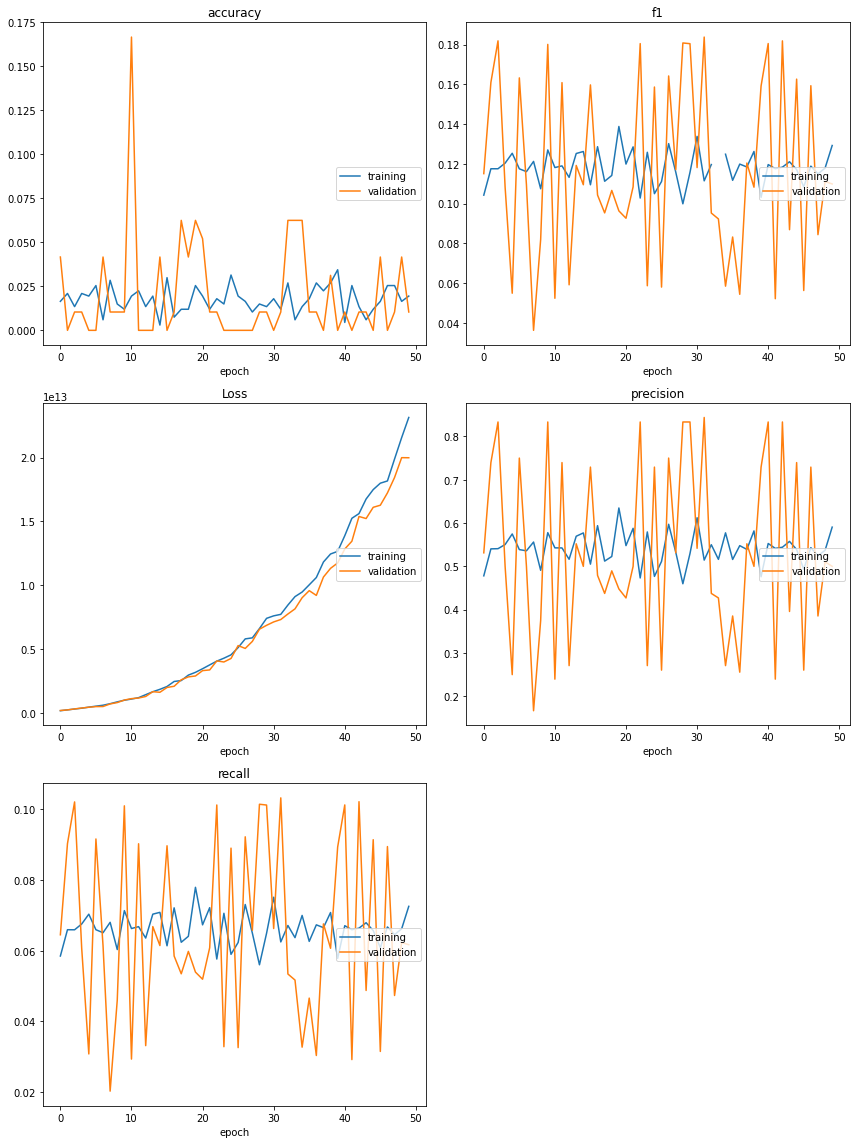

accuracy
	training         	 (min:    0.003, max:    0.034, cur:    0.019)
	validation       	 (min:    0.000, max:    0.167, cur:    0.010)
f1
	training         	 (min:    0.100, max:    0.139, cur:    0.129)
	validation       	 (min:    0.036, max:    0.184, cur:    0.110)
Loss
	training         	 (min: 175743680512.000, max: 23149764673536.000, cur: 23149764673536.000)
	validation       	 (min: 196431757312.000, max: 20000813350912.000, cur: 19993945178112.000)
precision
	training         	 (min:    0.460, max:    0.635, cur:    0.591)
	validation       	 (min:    0.167, max:    0.844, cur:    0.500)
recall
	training         	 (min:    0.056, max:    0.078, cur:    0.073)
	validation       	 (min:    0.020, max:    0.103, cur:    0.062)
21/21 [==============================] - 23s 1s/step - loss: 23149764673536.0000 - accuracy: 0.0195 - recall: 0.0726 - precision: 0.5906 - f1: 0.1292 - val_loss: 19993945178112.0000 - val_accuracy: 0.0104 - val_recall: 0.0617 - val_precision: 0.5000 

In [27]:
print("debut fit")
model.fit(x=training_generator,
            steps_per_epoch=training_generator.n // training_generator.batch_size,
            validation_data=validation_generator,
            validation_steps=validation_generator.n // validation_generator.batch_size,
            callbacks=[PlotLossesKerasTF()],
            epochs=50)

In [49]:
#reload_ext tensorboard

In [48]:
#%tensorboard --logdir Graph/fit

# Vérification de l'enregistrement du modèle

os.listdir(checkpoint_dir)

In [49]:
print("Récupération du modèle")
model = load_model(MODEL_PATH, custom_objects={"f1": f1, "recall": recall,"precision": precision}, compile=True)

Récupération du modèle


# Testing

In [29]:
#print(testing_generator.batch_size)

In [28]:
'''
model.evaluate(
    x=testing_generator,
    batch_size=testing_generator.batch_size,
    return_dict=True,
    steps=testing_generator.n // testing_generator.batch_size
)
'''

'\nmodel.evaluate(\n    x=testing_generator,\n    batch_size=testing_generator.batch_size,\n    return_dict=True,\n    steps=testing_generator.n // testing_generator.batch_size\n)\n'

# Calcul des prédictions du modèle sur les données de test

In [52]:
print("debut prediction")
predictions = model.predict(testing_generator,
                              steps=testing_generator.n // testing_generator.batch_size,
                              verbose=1)
print("fin prediction")

debut prediction
6/6 [==============================] - 1s 39ms/step
fin prediction


# Mise en forme des prédictions

In [104]:
images_path = []
predicted_titles = []
pred_labels = []

In [105]:
seuil_confiance = 40

In [106]:
for prediction_index, prediction in enumerate(predictions):
    predicted_title = []
    for i in range(len(prediction)):
        if prediction[i]*100 >seuil_confiance :
            predicted_title.append(unique_labels[i] + " %.1f" % (prediction[i]*100) + "%")
            pred_labels.append(unique_labels[i])
    images_path.append(testing_generator.filenames[prediction_index])
    predicted_titles.append(predicted_title)

In [107]:
def difference(index) : 
    line = df_old.loc[df_old['image_id'] == images_path[index]]
    sub_y = []
    for i in line.columns[1:] :
        sub_y.append(line[i].values[0])
    
    pred_y = [-1]*len(sub_y)
    for j in range(len(unique_labels)) :
        if unique_labels[j] in pred_labels[index]:
            pred_y[j] = 1
            
    drop_features = []
    correctness = 0
    for i in range(len(unique_labels)) :
        if sub_y[i] == pred_y[i]:
            correctness += 1
            drop_features.append(0)
        else :
            drop_features.append(1)
            
    correctness = correctness*100 / len(pred_y)
    return correctness, drop_features

# Calcul de proximité et d'influence

In [108]:
accuracy = 0
drop_features = {j:0 for j in unique_labels}

In [109]:
for i in range(len(images_path)):
    test = difference(i)
    for feat in range(len(test[1])):
        drop_features[unique_labels[feat]]+=test[1][feat]
    accuracy += test[0]

# Proximité et influence des labels

In [110]:
print("Proximité moyenne avec les labels réels : ",accuracy/len(images_path),"%")
print("Labels et le nombre de fois où ils étaient faux : ", dict(sorted(drop_features.items(), key=lambda item: item[1], reverse=True)))

Proximité moyenne avec les labels réels :  67.52604166666667 %
Labels et le nombre de fois où ils étaient faux :  {'Rosy_Cheeks': 165, 'Wearing_Lipstick': 104, 'No_Beard': 95, 'Bald': 93, 'Pale_Skin': 90, 'Oval_Face': 86, 'Mustache': 66, 'Wearing_Necktie': 53, 'Straight_Hair': 52, 'Blond_Hair': 48, 'Sideburns': 48, 'Young': 48, 'Bags_Under_Eyes': 47, 'Brown_Hair': 43, 'Wearing_Necklace': 42, 'Bangs': 41, 'Black_Hair': 41, 'Big_Nose': 39, 'Mouth_Slightly_Open': 35, 'Bushy_Eyebrows': 33, 'Eyeglasses': 31, 'Goatee': 25, 'Receding_Hairline': 25, 'Wavy_Hair': 25, '5_o_Clock_Shadow': 22, 'High_Cheekbones': 22, 'Smiling': 22, 'Male': 19, 'Wearing_Earrings': 15, 'Chubby': 13, 'Heavy_Makeup': 11, 'Big_Lips': 10, 'Pointy_Nose': 10, 'Wearing_Hat': 8, 'Gray_Hair': 7}


In [ ]:
print("Fin")
#regarder quelles sont les features qui font chuter le plus (les plus subjectives)

# Test sur un dossier avec des images personnelles

In[262]:


<br>
f = "test"<br>
for files in os.listdir(f):<br>
    f_img = f+"/"+files<br>
    img = Image.open(f_img)<br>
    img = img.resize((224,224))<br>
    img.save(f_img)<br>
print("Images resized !")<br>


In[263]:


<br>
predictions =  []<br>
images_path = []<br>
labels_images = []<br>
best_labels = []<br>
seuil_confiance = 40<br>
for file in os.listdir(f):<br>
    f_img = f+"/"+file<br>
    <br>
    #load image<br>
    my_image = load_img(f_img, target_size=(224, 224))<br>
    #preprocess the image<br>
    my_image = img_to_array(my_image)<br>
    my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))<br>
    my_image = preprocess_input(my_image)<br>
    <br>
    #make the prediction<br>
    pred_values = model.predict(my_image)<br>
    predictions.append(pred_values)<br>
    images_path.append(file)<br>
    <br>
    #enregistre les meilleurs labels<br>
    best = []<br>
    labels = []<br>
    <br>
    for i in range(len(pred_values[0])):<br>
        if pred_values[0][i]*100 > seuil_confiance :<br>
            best.append(unique_labels[i] + " %.1f" % (pred_values[0][i]*100) + "%")<br>
        labels.append(unique_labels[i] + " %.1f" % (pred_values[0][i]*100) + "%")<br>
        <br>
    best_labels.append(best)<br>
    labels_images.append(labels)<br>
     

In[264]:


<br>
for image in range(len(images_path)):  <br>
    print(images_path[image])<br>
    print("Best labels : ")<br>
    print(best_labels[image])<br>
